# Re-formatting plankton-specific marker genes fetched from different sources to create a custom database (DB) compatible with the metagenomics-based taxonomic profiling tool [Motus](https://www.nature.com/articles/s41467-019-08844-4).  

See Motus' GitHub repo [here](https://github.com/motu-tool/mOTUs).

### NOTE: we use a tool called [read_counter](https://github.com/AlessioMilanese/read_counter), which is a wrapper to run Motus using a customized DB.

Importantly, the default reference DB of marker genes used by Motus is not suitable for profiling marine planktonic ecosystems. Therefore we will create a plankton-specific marker gene DB to quantify relative abundance profiles across taxonomic groups. To achieve this, we will build on two well curated marker gene DBs: 

   - The huge catalog of phytoplankton *psbO* marker gene sequences, which encodes the manganese-stabilising polypeptide of the photosystem II oxygen evolving complex,  reported in this [paper](https://onlinelibrary.wiley.com/doi/epdf/10.1111/1755-0998.13592) and accessible [here](https://www.ebi.ac.uk/biostudies/studies/S-BSST761?query=A%20robust%20approach%20to%20estimate%20relative%20phytoplankton%20cell%20abundances%20from%20metagenomes). 

   - The [MZGdb](https://metazoogene.org/MZGdb) database and most specifically the "All Plankton Combo" files contain all data from the All Zooplankton and the All Ichthyoplankton combined files. This database was described in this [paper](https://link.springer.com/article/10.1007/s00227-021-03887-y). Here we will focus on DNA sequences for the barcode region of mitochondrial cytochrome oxidase I (COI).
   
#### The code developed in this Notebook is meant for developing our first proof-of-concept (POC1) biodiversity data asset, which focuses on the taxonomic composition found in a given environmental sample. In a nutshell, we assess relative abundances across numerous plankton taxonomic groups from metagenomics (MTG) datasets.  


In [ ]:
###NOTE:Uncomment below for pip install for outside requirements
# !pip3 install -r requirements.txt

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import colorsys
from matplotlib.collections import PatchCollection

import Bio.SeqIO as bioseqio
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
#from Bio.Alphabet import IUPAC
from Bio import Entrez

from ete3 import NCBITaxa
from taxonomy_ranks import TaxonomyRanks

from subprocess import Popen, call, STDOUT, PIPE
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib
import json
import glob
import re
import gzip
import sys
import csv
import time
import io
import pathlib
from collections import OrderedDict
import configparser

import pickle
import bz2 

from IPython.display import Image
from itertools import combinations
import itertools

In [2]:
pd.set_option('mode.chained_assignment', None)
matplotlib.rcParams['savefig.dpi'] = 1000
matplotlib.rcParams['figure.dpi'] = 1000
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper")
sns.set(font='serif')
sns.set_style('ticks')

In [3]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
###Uncomment below if necessary
rendef = "png" #"pdf" 
fig_renderer = pio.renderers[rendef]
fig_renderer.width = 1000
fig_renderer.height = 1000
pio.renderers.default = rendef

Utility functions

In [4]:
def format_tax_lbl(taxid = '94617'):
    """Function to properly format taxonomic labels using NCBI notation"""
    
    tax_lvls_lbls = ['species','genus','family', 'order', 'class', 'phylum', 'superkingdom'][::-1]
    rank_taxon = TaxonomyRanks(taxid)
    rank_taxon.get_lineage_taxids_and_taxanames()
    rank_dict =  list(rank_taxon.lineages.values())[0]
    tax_tree = list(rank_taxon.lineages.values())[0]
    
    #Parsing info on high rank tanks is optional, but can be quite handy when low ranks are unclassified: for higher rank assignment purposes if needed
    tax_ranks_list = [tax_tree[t][0].replace("NA","unclassified") for t in tax_lvls_lbls]
    ncbi_taxIDs_list = [str(tax_tree[t][1]) for t in tax_lvls_lbls]
    return ncbi_taxIDs_list,tax_ranks_list 

def parse_lineage(lineage_str):
    '''Function to correctly parse lineage using NCBI tax ID'''
    return (";".join(format_tax_lbl(lineage_str.split(';')[-1].replace('_', ' '))[-1])).replace(" ","_")

The following file names must be specified through the config.ini file to ensure that all the data is loaded successfully!

In [5]:
#Read config.ini file
config_obj = configparser.ConfigParser()
config_obj.read("configfile.ini")
user_info = config_obj["user_info"]
input_output_file_names = config_obj["input_output_file_names"]
database_setup = config_obj["database_setup"]

# *Always* tell NCBI who you are
Entrez.email = user_info["user_email"]

#Dumping our select marker gene set into this fasta file
custom_db_fasta_fid = input_output_file_names["custom_db_fasta_fid"]

#COI zooplankton db file name
coi_zooplankt_db_fid = input_output_file_names["coi_zooplankt_db_fid"]

#Original psbO DB
psbO_db_fid = input_output_file_names["psbO_db_fid"]
#Check if rebuild of DB is needed upon e.g. new marge genes become publicly available
rebuild_database = eval(database_setup["rebuild_database"])

### Processing/filtering COI (mitochondrial cytochrome oxidase I gene) sequences for Zooplankton species

In [6]:
coi_zooplankt_df = pd.read_csv(coi_zooplankt_db_fid, header=None, low_memory=False)

A COI sequence from this highly curated gene sequence database looks like this 

In [7]:
print(coi_zooplankt_df.iloc[1,30])

gatattggtactctctatttattaagagggatttgatcgggaatgattggcaggagattaagagttttaatccggttagaactgacccaaggaggaacatttttaggtaatgaccaactttataacgtagtagtcacagctcacgcttttgtaataattttttttatagtgatacccattttaattgggggttttggtaattggttagtgcctttaataattggggccccggatatggctttcccccgattaaataatataagattttgatttttaattccttccctttttatactggtatcaagtataataactgagaggggtgcagggacagggtgaactgtttaccctcccttaagaagaaatattagtcacgccggctcctcagttgatttagtaattttttctttgcatttagccggggtttcttcaattttgggggctttaaattttatttcaacgattgttaatcttcgaacattggggttatttttagatcgtacccctttattttgttgagcagttttagtcactgcagttcttttactcttatctctgcctgtgttagctggtgcgattactatacttttgaccgatcggaacctcaacacatctttttatgaccctaggggaggaggagaccctgtgctttatcagcacctattttgattttttggt


In [8]:
print("This COI DB contains a total number of {} sequences".format(coi_zooplankt_df.shape[0]))

This COI DB contains a total number of 368637 sequences


The following chunk of code will perform filtering and reformatting of the headers of each sequence in the original COI DB

In [9]:
###Uncomment below to rebuild custom DB
filtered_coi_zooplankt_df = coi_zooplankt_df[coi_zooplankt_df.iloc[:,33].map(lambda s: isinstance(s, str))]
#Lets concentrate on organism name and corresponding COI sequence
min_coi_zooplankt_df = filtered_coi_zooplankt_df.iloc[:,[1,8,30]]
#Rename columns
#Use genebank accession to fetch a bunch of info needed to reformat headers
min_coi_zooplankt_df.columns = ["Species_name","Genebank_accession","Species_COI_seq"]
#Add full lineage
# min_coi_zooplankt_df['Full_lineage'] = filtered_coi_zooplankt_df.iloc[:,33].map(lambda s: ";".join([l for l in s.split(';') if '_EXT' not in l and l!='']))
min_coi_zooplankt_df['Full_lineage'] = filtered_coi_zooplankt_df.iloc[:,33]
#Here we drop duplicate marker genes
min_coi_zooplankt_df.drop_duplicates(['Species_COI_seq'],inplace=True)

#Removing duplicate lineages. Use info to fetch from NCBI a much better taxonomic description
unique_lineages = min_coi_zooplankt_df["Full_lineage"].value_counts().index

#Fetch lowest tax rank to be used to query the NCBI tax DB
lowest_tax_ranks = unique_lineages.map(lambda s: s.split(";")[-2].replace("_EXT", "").replace("_", " "))

#Set dict for mapping raw to polished tax lbls
raw2polished_taxlbls = OrderedDict()

#Generating a much nicer way to label taxonomy. Original label was a total mess
tax_lvls_lbls = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
for (k,v) in zip(unique_lineages,lowest_tax_ranks):
    try:
        tax_tree_lbl = ";".join(["".join(s) for s in zip(tax_lvls_lbls, format_tax_lbl(taxid = v)[1])]).replace(" ","_")
        raw2polished_taxlbls[k] = tax_tree_lbl
    except:
        raw2polished_taxlbls[k] = np.nan
        
#Redefine column with a more elegant tax tree description
min_coi_zooplankt_df["Full_lineage"] = min_coi_zooplankt_df["Full_lineage"].map(raw2polished_taxlbls)
#Drop those annoying NAN entries
min_coi_zooplankt_df.dropna(inplace=True)
min_coi_zooplankt_df.reset_index(drop=True, inplace=True)

In [10]:
min_coi_zooplankt_df

,Species_name,Genebank_accession,Species_COI_seq,Full_lineage
0,Acanthochondria ophidii,MT193877,attggtactctctatttattaagagggatttgatcgggaatgattg...,k__Eukaryota;p__Arthropoda;c__Hexanauplia;o__P...
1,Acanthochondria ophidii,MT193878,gatattggtactctctatttattaagagggatttgatcgggaatga...,k__Eukaryota;p__Arthropoda;c__Hexanauplia;o__P...
2,Acanthochondria ophidii,MT193879,aaagatattggtactctctatttattaagagggatttgatcgggaa...,k__Eukaryota;p__Arthropoda;c__Hexanauplia;o__P...
3,Acanthochondria ophidii,MT193880,gatattggtactctctatttattaagagggatttgatcgggaatga...,k__Eukaryota;p__Arthropoda;c__Hexanauplia;o__P...
4,Acanthochondria ophidii,MT193881,aaagatattggtactctctatttattaagagggatttgatcgggaa...,k__Eukaryota;p__Arthropoda;c__Hexanauplia;o__P...
...,...,...,...,...
229883,Galaxias zebratus,KC821874,agtcaaccaggagctcttttgggtgacgatcaaatttataatgtaa...,k__Eukaryota;p__Chordata;c__Actinopteri;o__Gal...
229884,Galaxias zebratus,KC821875,agtcaaccaggagctcttttgggtgacgatcaaatttataatgtaa...,k__Eukaryota;p__Chordata;c__Actinopteri;o__Gal...
229885,Galaxias zebratus,KC821876,agtcaaccaggagctcttctgggtgacgatcaaatttataatgtaa...,k__Eukaryota;p__Chordata;c__Actinopteri;o__Gal...
229886,Lovettia sealii,KJ669505,cctctatctagtatttggtgcatgagcaggaatggtcggcacagct...,k__Eukaryota;p__Chordata;c__Actinopteri;o__Gal...


Visualizing taxonomic coverage of marker gene sequences in our database of Holoplankton and Meroplankton organisms

In [12]:
#Get counts of marker genes per taxon
mg_counts_per_taxon = min_coi_zooplankt_df["Full_lineage"].value_counts()
#Summary of marker genes for zoo and other non-phyto, including fish and crustacea
get_records = mg_counts_per_taxon.index.map(lambda s: [sbs.split(";")[0] for sbs in s.split("__")[1:]]).values
zooplank_marker_genes_summary = pd.DataFrame.from_records(get_records)
zooplank_marker_genes_summary.columns = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
zooplank_marker_genes_summary["log_abundance"] = np.log10(mg_counts_per_taxon.values)

In [78]:
###Uncomment below to visualize for everything except phytoplankton... Full representations is shown below
# fig = px.sunburst(zooplank_marker_genes_summary,#.query('superkingdom == "Eukaryota"'), 
#                   path=['superkingdom','phylum', 'class', 'order', 'family', 'genus'], 
#                   values='log_abundance', color='phylum')

# fig.update_layout(
#                 title={
#                     'text': "Taxonomic coverage of Holoplankton and Meroplankton in NA marker gene database",
#                     'y':0.985,
#                     'x':0.5,
#                     'xanchor': 'center',
#                     'yanchor': 'top',
#                     'font_size':20,
#                     'font_color':"black"})


# # fig.update_yaxes(automargin=True)
# # fig.update_xaxes(automargin=True)

# fig.update_layout(
#     autosize=False,
# #     width=500,
# #     height=500,
#     margin=dict(
#         l=1,
#         r=1,
#         b=4,
#         t=50,
#         pad=2
#     ),
#     paper_bgcolor="White",
# )

# fig.show(width=1000, height=1000)

Iterating over each row in the filtered DF and creating a Seq object with formatted header, which is dumped into the dedicated file

In [293]:
# !grep -c '>'  ../../data/custom_db/CustomPhytoZooPlanktonMGs.fna

In [16]:
#Check whetther to rebuild DB through rebuild_database var set via configfile
if rebuild_database:
    for i,seq_rec in min_coi_zooplankt_df.iterrows():
        #Create seq record on the fly
        record = SeqRecord(
        Seq(seq_rec['Species_COI_seq']),
        id = "COI_" + seq_rec['Genebank_accession'] + '|' + seq_rec['Full_lineage'],
        name="",
        description="")

        with open(custom_db_fasta_fid, "a") as output_handle:
            bioseqio.write(record, output_handle, "fasta")       

### Processing/filtering psbO sequences for Phytoplankton species.

Adding to fasta file already created above.  
An entry in the psbO DB (fasta format) looks as follows:

In [20]:
!head $psbO_db_fid -n 20

>BIMP01000001.1_cds_GCE64567.1_468__138-855 Bacteria;Cyanobacteria;Synechococcales;Synechococcaceae;Synechococcus;Synechococcus_symbiont_of_Ornithocercus_magnificus Reference=Nakayama_et_al_2019_PNAS_116_15973-15978 [locus_tag=OMCYN_00483] [protein=photosystem II manganese-stabilizing polypeptide] [protein_id=GCE64567.1] [location=complement(461303..462169)] [gbkey=CDS]
CAGCATCACGTATGACGACATCCGGAACACTGGTCAGGCAAATGATTGCCCAACCTTACCAGAGTCTGCCCGAGGCTCAA
TCGAACTTGTTGCTGGTGGCAGTTATCAGTTGCGTGAGATGTGTCTTCATCCTGAACAAGTCTATATTAAAGGCGAGCCA
GCAAGCAAACGACAAGAAGCCAAATTTGTTGAGGGTAAAATCCTGACTCGTTATACATCTAGCTTAGACCAGGTCTACGG
ATCTTTGACAGTGAATGATGATGGTCTTAGCTTTGCTGAAGAGGGAGGTATTGACTTCCAGCCAATCACAGTTCTAACAC
CTGGAGCCGAAGAATATCCTTTCACTTTCTCGAGCAAGAACCTTAGGGCTACAGCCACTGGTGACTCTATTACCACCAGT
ACCGATTTTGAAGGCACTTATAGGACACCTAGCTATCGCACAAGTAATTTCATCGATCCCAAAGGTCGTGCACTCACGAC
TGGAGTTGACTATGCACAGGGTCTCATTGCTTTAGGTGGTGATGATGCAGAGTTAGCTACCGAAAACGTGAAGCGCTACA
TCGATGGTACTGGCTTGATGAACTTGTCAATTACGCGGGTCGACCCAGAGACTGGCGAGT

In [11]:
#Total number of sequences in the original psb0 DB
!grep -c '>' $psbO_db_fid

20043


Processing and filtering the psbO marker gene database

In [38]:
#Check whetther to rebuild DB through rebuild_database var set via configfile
if rebuild_database:
    #Set pattern for taxonomic labeling
    tax_lvls_lbls = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']

    #Uncomment below to rebuild custom DB
    with open(psbO_db_fid, "r") as handle:
        for (i,record) in enumerate(bioseqio.parse(handle, "fasta")):
            #Changing individual seq headers
            if len(record.description.split(' '))>=2:
                tax_str = record.description.split(" ")[1].replace("_", " ").split(";")[-1]
                try:
                    tax_tree = format_tax_lbl(tax_str)[1]
                    tax_str = ";".join(["".join(s) for s in zip(tax_lvls_lbls, tax_tree)]).replace(" ","_")
                    #Append full marker gene seq description
                    full_mg_descrip = "psbO_" + record.description.split(" ")[0] + "|" + tax_str
                    #Change fasta header accordingly
                    record.description=''
                    record.id = full_mg_descrip
                    ###Dump to fasta
                    with open(custom_db_fasta_fid, "a") as output_handle:
                        bioseqio.write(record, output_handle, "fasta") 

                except:
                    pass

### Our final DB (concatenated gene markers for both Phyto and Zooplankton species)

In [12]:
print("Total number of marker genes included in our customized DB of marker genes is:")
!grep -c '>' $custom_db_fasta_fid

Total number of marker genes included in our customized DB of marker genes is:
245562


#### Database must be built/indexed before using it for taxonomic profiling via the `read_counter` tool.  
To achieve this, you'll have to run the following command:

`./read_counter index -db $custom_db_fasta_fid`  

**NOTE:** make sure that the bwa tool is on the `$PATH` before running the above command.

The indexing of the database will output the following files absolutely necessary for taxonomic profiling:

```
CustomPhytoZooPlanktonMGs_v1.0.fna.coords
CustomPhytoZooPlanktonMGs_v1.0.fna.sa
CustomPhytoZooPlanktonMGs_v1.0.fna.amb
CustomPhytoZooPlanktonMGs_v1.0.fna.ann
CustomPhytoZooPlanktonMGs_v1.0.fna.pac
CustomPhytoZooPlanktonMGs_v1.0.fna.bwt
```

Taxonomic profiling of a given metagenomics sample (`mtg_sample.fq`) can then obtained by running:  
`./read_counter map -db $custom_db_fasta_fid -s test/mtg_sample.fq -o test/RES_temp`

In [37]:
!pwd

/kyukon/data/gent/vo/001/gvo00125/vsc43582/Bioinformatics/Planktomics/new-atlantis-dao/Metagenomics/notebooks/Custom_DB_MTG


In [38]:
!ls -lth ../../data/custom_db/

total 1.8G
-rw-r--r-- 1 vsc43582 vsc43582 180M Sep 15 23:05 CustomPhytoZooPlanktonMGs_v1.0.fna
-rw-r--r-- 1 vsc43582 vsc43582  54M Sep 14 10:01 CustomPhytoZooPlanktonMGs.fna
-rw-rw-r-- 1 vsc43582 vsc43582 527M Sep 14 09:56 MZGdata-coi__MZGdbALL__o00__A.csv
-rw-rw-r-- 1 vsc43582 vsc43582  12M Sep 14 09:54 psbO_20210825.fna
-rw-r--r-- 1 vsc43582 vsc43582  18M Aug 24 22:37 DB.sa
-rw-r--r-- 1 vsc43582 vsc43582 8.8M Aug 24 22:37 DB.pac
-rw-r--r-- 1 vsc43582 vsc43582  15M Aug 24 22:37 DB.coords
-rw-r--r-- 1 vsc43582 vsc43582  35M Aug 24 22:37 DB.bwt
-rw-r--r-- 1 vsc43582 vsc43582 8.5M Aug 24 22:37 DB.ann
-rw-r--r-- 1 vsc43582 vsc43582 110K Aug 24 22:37 DB.amb
-rw-r--r-- 1 vsc43582 vsc43582  43M Aug 24 22:37 DB


#### Visualizing full taxonomic coverage of NewAtlantis plankton (Zoo/Phyto/Holo/Meroplankton) marker genes database used to taxonomically profile metagenomic samples

In [69]:
#Fetch fasta headers and create df from taxonomic annotations
tax_tree_desc_cont = []
with open(custom_db_fasta_fid, "r") as handle:
    for (i,record) in enumerate(bioseqio.parse(handle, "fasta")):
        tax_tree_desc_cont.append([s.split("__")[-1] for s in record.id.split("|")[-1].split(";")])

In [75]:
#Create summary of gene marker representation across species
full_tax_count_mg_db = pd.DataFrame(tax_tree_desc_cont, columns=['species','genus','family', 'order', 'class', 'phylum', 'superkingdom'][::-1])
multi_index_counts = full_tax_count_mg_db.value_counts().map(np.log10)
multi_index_counts.name = "log_abundance"

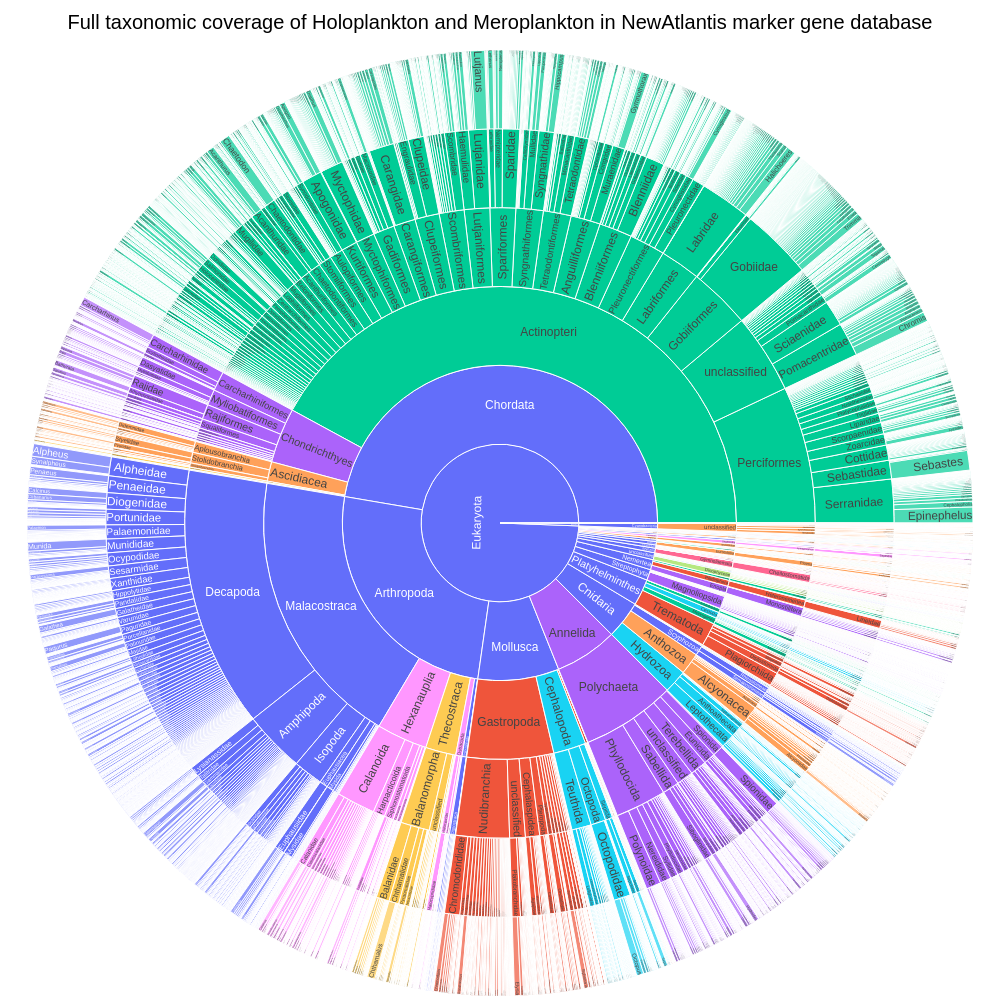

In [90]:
fig = px.sunburst(multi_index_counts.reset_index(),#.query('superkingdom == "Eukaryota"'), 
                  path=['superkingdom','phylum', 'class', 'order', 'family', 'genus'], 
                  values='log_abundance', color='class')

fig.update_layout(
                title={
                    'text': "Full taxonomic coverage of Holoplankton and Meroplankton in NewAtlantis marker gene database",
                    'y':0.985,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top',
                    'font_size':20,
                    'font_color':"black"})


# fig.update_yaxes(automargin=True)
# fig.update_xaxes(automargin=True)

fig.update_layout(
    autosize=False,
#     width=500,
#     height=500,
    margin=dict(
        l=1,
        r=1,
        b=4,
        t=50,
        pad=2
    ),
    paper_bgcolor="White",
)

fig.show(width=1000, height=1000)
# pio.write_image(fig, "CustomProkEukDB/SunburstTaxDist_DB_v2.3.png", width=1.5*1000, height=1*1000, scale =1.25)

### With the customized marker gene DB (for both zooplankton --COI sequences-- & phytoplankton --psbO sequences--) created above we can screen across metagenomic datasets in order to assess the taxonomic composition of the plankton community sequenced.

#### A short read in a MTG file looks like this:  

```@ERR1719507.4222 H2:D1NNJACXX:6:1101:5303:2333/1
AGCGAGCCCACTGTGTTCCCGGGGGACTGGGGGCCATTAGCGGCGTCAGACACGGGGGGGAGCGGGGTCTGACCATCCTGGGCCGGGACCCGGCCGTCCAGTTTGTCCAGCATGGCCCGGGCCGCCCCGTGCTTGGCCTGCTTCTTG
+
CCCFFFFFHHHHGGIIJJJJIJJJJGHIJJJJHDDDDDDDDDDCDBJJJHIGJJJJJJJJJJIJJJJJJJJIJJJJJJJJJJJJJJJEJJJJJJJJJJJJJDDDDDDDDDDDDDDDDDFFHJJIIJJJJJIJJJHGHHHFFFFFCCC```

In [1]:
pwd

'/dodrio/scratch/projects/starting_2022_048/NAD/Metagenomics/notebooks/Custom_DB_MTG'